In [11]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle
optimization/btest015.pickle
optimization/btest016.pickle
optimization/btest017.pickle
optimization/btest018.pickle
optimization/btest019.pickle
optimization/btest020.pickle
optimization/btest021.pickle
optimization/btest022.pickle
optimization/btest023.pickle
optimization/btest024.pickle
optimization/btest025.pickle
optimization/btest026.pickle
optimization/btest027.pickle
optimization/btest028.pickle
optimization/btest029.pickle
optimization/btest030.pickle
optimization/btest031.pickle
optimization/btest032.pickle
optimization/btest033.pickle
optimization/b

In [20]:
from backtest import DataParser, MovingWindow
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from indicators import ZigZag


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 50
tfdict = {"M5":0, "M15":1, "H1":2}
zz = ZigZag()
Xl, Xs, yl, ys, odates, poslist = [], [], [], [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[1:]:
        f, _ = mw(pos.open_indx)
        fc = f.Close[-5:-2]/f.Close[-2]
        fo = f.Open[-5:-2]/f.Open[-2]
        fh = f.High[-5:-2]/f.High[-2]
        fl = f.Low[-5:-2]/f.Low[-2]
        fv = f.Volume[-5:-2]/f.Volume[-2] if f.Volume[-2] != 0 else f.Volume[-5:-2]*0
        ids_, vals_, tps_ = zz.update(f)
        vals, ids, tps = np.zeros((3, 8))
        vals[:min(8, len(vals_))] = vals_[:8]/f.Close[-2]
        ids[:min(8, len(vals_))] = f.Id[-1] - ids_[:8]
        tps[:min(8, len(vals_))] = tps_[:8]
        odate = pd.to_datetime(pos.open_date)
        odate = odate.year*10000 + odate.month*100 + odate.day
        if pos.dir == 1:
            Xl.append(np.hstack([fc, fo, fl, fh, fv, ids, vals, tps, btest.cfg.stops_processor.func.cfg.sl, btest.cfg.stops_processor.func.cfg.tp, odate, tfdict[btest.cfg.period]]))
            yl.append(pos.profit)
        else:
            Xs.append(np.hstack([2-fc, 2-fo, 2-fl, 2-fh, fv, ids, 2-vals, tps, btest.cfg.stops_processor.func.cfg.sl, btest.cfg.stops_processor.func.cfg.tp, odate, tfdict[btest.cfg.period]])) 
            ys.append(pos.profit) 
        poslist.append(pos)
        
Xs, Xl = np.array(Xs), np.array(Xl)
ys, yl = np.array(ys), np.array(yl)
odates = np.array(odates)

# ids2add = np.random.choice(np.arange(Xs.shape[0]), size=Xl.shape[0] - Xs.shape[0])
# Xs = np.vstack([Xs, Xs[ids2add]])
# ys = np.hstack([ys, ys[ids2add]])
X = np.vstack([Xs, Xl])
y = np.hstack([ys, yl])
print(Xs.shape, Xl.shape, X.shape, ys.shape, yl.shape, y.shape)

SBER 695
ROSN 476
LKOH 502
GMKN 465
GAZP 454
SBER 1584
ROSN 1333
LKOH 1283
GMKN 1330
GAZP 1282
SBER 650
ROSN 442
LKOH 452
GMKN 436
GAZP 414
SBER 1353
ROSN 1125
LKOH 1084
GMKN 1086
GAZP 1036
SBER 623
ROSN 421
LKOH 421
GMKN 414
GAZP 390
SBER 1190
ROSN 994
LKOH 931
GMKN 924
GAZP 897
SBER 634
ROSN 427
LKOH 443
GMKN 407
GAZP 388
SBER 1331
ROSN 1056
LKOH 1031
GMKN 1079
GAZP 1036
SBER 578
ROSN 385
LKOH 379
GMKN 367
GAZP 329
SBER 1064
ROSN 826
LKOH 793
GMKN 833
GAZP 774
SBER 528
ROSN 353
LKOH 329
GMKN 346
GAZP 306
SBER 903
ROSN 693
LKOH 651
GMKN 680
GAZP 622
SBER 603
ROSN 388
LKOH 402
GMKN 375
GAZP 357
SBER 1171
ROSN 915
LKOH 885
GMKN 925
GAZP 868
SBER 520
ROSN 337
LKOH 332
GMKN 329
GAZP 289
SBER 903
ROSN 675
LKOH 634
GMKN 668
GAZP 610
SBER 479
ROSN 302
LKOH 287
GMKN 291
GAZP 260
SBER 757
ROSN 537
LKOH 493
GMKN 530
GAZP 484
(28018, 43) (32756, 43) (60774, 43) (28018,) (32756,) (60774,)


45561 15213
000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15:+2070.7 -> +2028.1 --
000 profit H1 : +608.0 ->  +455.2 --
000 mae_train: 1.14 mae_test: 1.78
[   0.         2070.67844542  607.97978158]  ->  [   0.         2028.05098912  455.18127015]
[        nan -0.02058623 -0.2513217 ]
mae_train: 1.14 mae_test: 1.78 ration: 1.55
av. profit boost: -0.07295666380756845


/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_10347/2418472640.py:82: RuntimeWarning: invalid value encountered in divide
  print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))


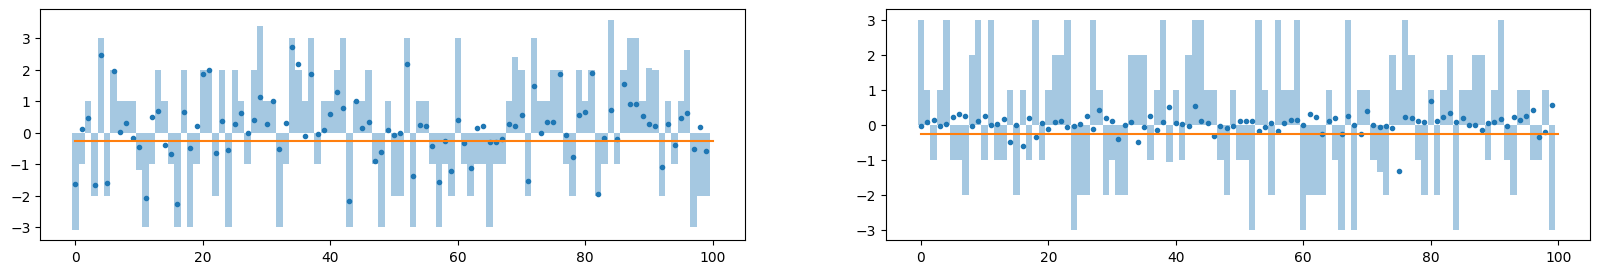

In [26]:
nitrers = 1
test_split = 0.25
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    ids = np.arange(X.shape[0])
    # np.random.shuffle(ids)
    test_size = int(X.shape[0]*test_split)
    ids_test, odates_testset, odates = [], set(), X[:, -2]
    while len(ids_test) < test_size:
        ix = np.random.randint(0, X.shape[0])
        d = odates[ix]
        if d not in odates_testset:
            ii = ids[odates == d]
            ids_test += ii.tolist()
            odates_testset.add(d)
    ids_train = [ix for ix in ids if ix not in ids_test]   
    np.random.shuffle(ids_train) 
    np.random.shuffle(ids_test) 
        
    # ids_test, ids_train = ids[:test_size], ids[test_size:]
    X_train, X_test, y_train, y_test = X[ids_train], X[ids_test], y[ids_train], y[ids_test]
    tf_test = X_test[:, -1]
    X_train = X_train[:, :-2]
    X_test = X_test[:, :-2]
    profs_test = y_test
    profs_train = y_train
    # y_train = (y_train > 0).astype(int)
    # y_test = (y_test > 0).astype(int)

    # scaler = StandardScaler() 
    # scaler.fit(X_train) 
    # X_train = scaler.transform(X_train) 
    # X_test = scaler.transform(X_test) 
    
    # X_add = X_train + np.random.random(X_train.shape)*0.1
    # X_train = np.vstack([X_train, X_add])
    # y_train = np.hstack([y_train, y_train])
    
    print(X_train.shape[0], X_test.shape[0])
    # evals_result = {}
    # model = lgb.train(params=dict(objective="binary", 
    #                             # metric="auc",
    #                             # num_leaves=2, 
    #                             max_depth=3,
    #                             verbose=-1), 
    #                   train_set=lgb.Dataset(X_train, label=y_train),
    #                   valid_sets=[lgb.Dataset(X_test, label=y_test)],
    #                   num_boost_round=500,
    #                   feval=lgb_f1_score,
    #                   # evals_result=evals_result,
    #                   # verbose_eval=False,
    #                   callbacks=[log_evaluation(-1)]
    #                   )
    # lgb.plot_metric(evals_result, metric='f1')

    model = RandomForestRegressor(max_depth=20, n_estimators=200, min_samples_leaf=2)
    model.fit(X_train, y_train)
    threshold = -0.25
    if len(X_train):
        # p_train = model.predict(X_train)
        p_train = model.predict(X_train)
        # threshold = np.percentile(p_train, 10)
        metrics[0, i] = mean_absolute_error(p_train, y_train)
    # p_test = model.predict(X_test)
    p_test = model.predict(X_test)
    metrics[1, i] = mean_absolute_error(p_test, y_test)

    for j in range(3):
        ids = tf_test == j
        pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
        gprofits[j, i] = profs_test[ids].sum()
        print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    print(f"{i:03} mae_train: {metrics[0, i]:4.2f} mae_test: {metrics[1, i]:4.2f}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)
f1_mean = metrics.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ration: {f1_mean[1]/f1_mean[0]:4.2f}")
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])

000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15:+2070.7 -> +2105.7 OK
000 profit H1 : +608.0 ->  +544.9 --
[   0.         2070.67844542  607.97978158]  ->  [   0.         2105.68035757  544.90159049]
[        nan  0.0169036  -0.10375047]
av. profit boost: -0.010481471149101678


/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_10347/4162104487.py:12: RuntimeWarning: invalid value encountered in divide
  print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))


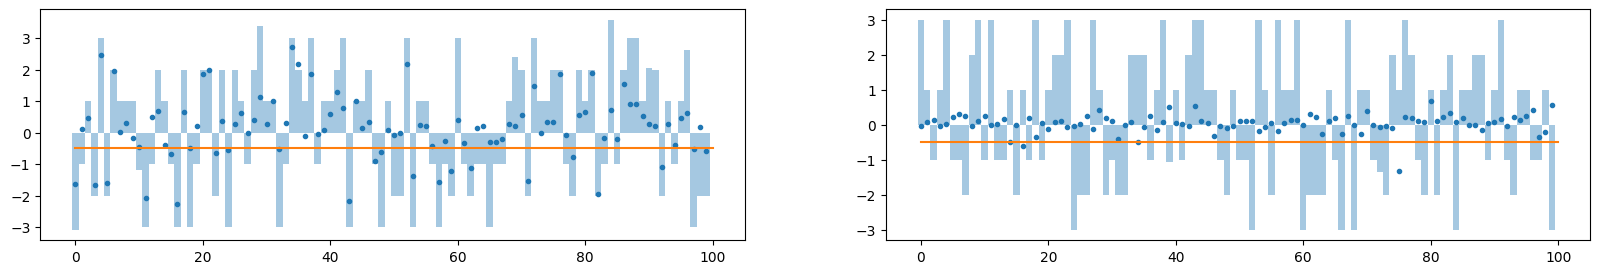

In [28]:
threshold = -0.5
for j in range(3):
    ids = tf_test == j
    pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
    gprofits[j, i] = profs_test[ids].sum()
    print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])

In [26]:
set(X_train[:, -1].astype(int)).intersection(set(X_test[:, -1].astype(int)))

{1, 2, 3}

In [114]:
print(" ".join(map("{:6.4f}".format, model.feature_importances_)))

0.0464 0.0397 0.0337 0.0634 0.0785 0.0459 0.0605 0.0414 0.0536 0.0481 0.0664 0.0818 0.0548 0.0591 0.0520 0.0000 0.0010 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0650 0.0530 0.0200 0.0062 0.0002 0.0001 0.0001 0.0005 0.0016 0.0009 0.0008 0.0002 0.0000 0.0000 0.0000 0.0000 0.0076 0.0173


In [391]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(1112, 3653, 3682, 3682)

In [ ]:
import mplfinance as mpf

ticker = "GAZP"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="metatrader"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [47]:
prediction

array([[0.49287947, 0.50712053]])